# Micuna
## From the Data to the Fields: Optimal Weather Conditions to Sow Crops

In this notebook, we develop a boosted ensemble of decision trees, XGBoost model, for the classification of optimal days for sowing. 
In this particular model, we work with data from the Soybean case.
We select three specific locations in the region of Santa Cruz, Bolivia, known for Soybean crops: Tres Cruces, Guarayos, and San Juan.

#### Libraries

In [1]:
import pandas as pd
import seaborn as sns

# Data extraction

Initial date: 01-01- 2020
End date: 10-03-2024

### The Power Project - Nasa

Source for the api: https://power.larc.nasa.gov/

In [2]:
def power_nasa(lat,long):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"

    params = {
        "start": "20200101", 
        "end": "20241003",     
        "latitude": lat,  
        "longitude": long, 
        "community": "AG",  
        "parameters": "QV2M,WD2M,PS,RH2M,PRECTOT,WS2M,WS50M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN"
                      ,  
        "format": "JSON"  
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()

        parameters = data['properties']['parameter']

        df_1_nasa = pd.DataFrame(parameters)

        df_1_nasa = df_1_nasa.reset_index() 

        df_1_nasa.rename(columns={'index': 'date'}, inplace=True)
    else:
        print(f"Error: {response.status_code}")

    
    
    
    return df_1_nasa 

## Open Meteo

API Documentation: https://open-meteo.com/en/docs/historical-weather-api 

In [3]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

###### Example of how to build the database from Meteo

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
 
params = {
	"latitude": -17.638442,
	"longitude": -62.260282,
	"start_date": "2020-01-01",
	"end_date": "2024-10-05",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum", "rain_sum", "precipitation_hours", "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(3).ValuesAsNumpy()
daily_rain_sum = daily.Variables(4).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(5).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(6).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(7).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

daily_dataframe = pd.DataFrame(data = daily_data)
# print(daily_dataframe)
daily_dataframe

Coordinates -17.60984230041504°N -62.234039306640625°E
Elevation 281.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,precipitation_hours,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2020-01-01 04:00:00+00:00,31.669500,22.869501,26.632002,0.6,0.6,3.0,20.340000,4.346330
1,2020-01-02 04:00:00+00:00,30.369501,23.169500,26.698664,5.5,5.5,5.0,17.629999,3.728637
2,2020-01-03 04:00:00+00:00,32.719501,24.019501,28.157000,0.5,0.5,3.0,25.639999,5.601533
3,2020-01-04 04:00:00+00:00,33.269501,24.019501,28.646584,0.0,0.0,0.0,27.549999,6.145042
4,2020-01-05 04:00:00+00:00,32.919502,24.369501,28.444504,0.3,0.3,1.0,25.309999,6.205818
...,...,...,...,...,...,...,...,...,...
1735,2024-10-01 04:00:00+00:00,38.019501,27.769501,32.519505,0.0,0.0,0.0,21.629999,9.192921
1736,2024-10-02 04:00:00+00:00,36.869499,27.469501,31.996588,0.0,0.0,0.0,19.799999,7.415186
1737,2024-10-03 04:00:00+00:00,33.719501,24.219501,28.369499,0.0,0.0,0.0,21.969999,7.930784
1738,2024-10-04 04:00:00+00:00,36.119499,22.519501,NaN,NaN,NaN,0.0,NaN,NaN


After retrieving data from the Open Meteo API, the target variable has been labeled with the following labels:
1 for optimal weather conditions
0 for non optimal weather conditions
The labeling is based in past local news articles, agriculture expertise (as a multidisciplinary team we count on an industry practitioner), and articles on weather conditions for Soybean.
Sources: 
- https://eos.com/blog/how-to-grow-soybeans/
- https://eju.tv/2023/12/campana-de-verano-2023-supeditada-a-las-lluvias-y-al-diesel/
- https://www.academia.edu/71188672/The_multi_year_soybean_grain_yield_depending_on_weather_conditions

## Reading labeled data

In [5]:
# San Juan
df_1 = pd.read_excel('DATOSHISTORICOSsanJuan.xlsx')
# Pozo Tigre
df_2 = pd.read_excel('DATOSHISTORICOSpozoTigre.xlsx')
# Tres Cruces
df_3 = pd.read_excel('DATOSHISTORICOStresCruces.xlsx')

## Location 1: San Juan

In [6]:
import requests

san juan
"latitude": -17.507429,
"longitude": -62.843276,

In [7]:
df_1_nasa = power_nasa(-17.507429,-62.843276)

In [8]:
df_1['date'] = df_1['date'].dt.strftime('%Y%m%d')

In this line, data from Meteo and Nasa is being merged into a single dataframe

In [9]:
df_1 = pd.merge(df_1, df_1_nasa, on='date', how='left')

In [10]:
df_1['rain_sum_now_7days'] = df_1['precipitation_sum'].rolling(window=8).sum()
df_1['rain_sum_7to14days'] = df_1['precipitation_sum'].shift(7).rolling(window=7).sum()
df_1['temp_sum_now_7days'] = df_1['temperature_2m_mean'].rolling(window=8).sum()
df_1['temp_avg_now_7days'] = df_1['temperature_2m_mean'].rolling(window=8).mean()

## Location 2: Tres Tigres

pozo tigre
-17.627575, -61.979184


In [11]:
df_2_nasa = power_nasa(-17.627575, -61.979184)

In [12]:
df_2['date'] = df_2['date'].dt.strftime('%Y%m%d')

In this line, data from Meteo and Nasa is being merged into a single dataframe:

In [13]:
df_2 = pd.merge(df_2, df_2_nasa, on='date', how='left')

In [14]:
df_2['rain_sum_now_7days'] = df_2['precipitation_sum'].rolling(window=8).sum()
df_2['rain_sum_7to14days'] = df_2['precipitation_sum'].shift(7).rolling(window=7).sum()
df_2['temp_sum_now_7days'] = df_2['temperature_2m_mean'].rolling(window=8).sum()
df_2['temp_avg_now_7days'] = df_2['temperature_2m_mean'].rolling(window=8).mean()

## Location 3: Tres Cruces


Tres cruces
-17.638442, -62.260282


In [15]:
df_3_nasa = power_nasa(-17.638442, -62.260282)

In [16]:
df_3['date'] = df_3['date'].dt.strftime('%Y%m%d')

In this line, data from Meteo and Nasa is being merged into a single dataframe

In [17]:
df_3 = pd.merge(df_3, df_3_nasa, on='date', how='left')

In [18]:
df_3['rain_sum_now_7days'] = df_3['precipitation_sum'].rolling(window=8).sum()
df_3['rain_sum_7to14days'] = df_3['precipitation_sum'].shift(7).rolling(window=7).sum()
df_3['temp_sum_now_7days'] = df_3['temperature_2m_mean'].rolling(window=8).sum()
df_3['temp_avg_now_7days'] = df_3['temperature_2m_mean'].rolling(window=8).mean()

# Data Processing

In [19]:
df_total = pd.concat([df_1, df_2, df_3], ignore_index=True)

In [20]:
df_total.fillna(0, inplace=True)

In [21]:
df_total.head()

,date,y,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,precipitation_hours,shortwave_radiation_sum,et0_fao_evapotranspiration,...,WD2M,PS,CLRSKY_SFC_SW_DWN,WS2M,WS50M,PRECTOTCORR,rain_sum_now_7days,rain_sum_7to14days,temp_sum_now_7days,temp_avg_now_7days
0,20200101,0.0,30.947500,22.347500,26.091248,8.0,8.0,12,21.559999,4.470323,...,152.31,96.97,29.39,1.20,2.84,3.05,0.0,0.0,0.0,0.0
1,20200102,0.0,30.497499,23.147499,26.526663,2.7,2.7,4,19.790001,4.079800,...,183.88,97.02,29.47,1.42,3.38,1.67,0.0,0.0,0.0,0.0
2,20200103,0.0,32.497501,23.847500,27.759996,0.2,0.2,1,26.520000,5.694897,...,171.88,97.11,30.01,1.90,4.22,0.08,0.0,0.0,0.0,0.0
3,20200104,0.0,33.047501,24.247499,28.395416,0.1,0.1,1,26.910000,5.986668,...,140.88,96.97,29.87,1.42,3.35,0.01,0.0,0.0,0.0,0.0
4,20200105,0.0,31.047501,24.447500,27.295416,1.0,1.0,6,23.010000,5.050601,...,316.06,96.67,29.00,2.74,6.32,1.60,0.0,0.0,0.0,0.0


# Classification Model: Gradient Boosting Ensemble of Decision Trees

### In this implementation, the XGBoost python library was used to train the classification model.
Documentation: https://xgboost.readthedocs.io/en/stable/

In [22]:
! pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [23]:
df_total.columns

Index(['date', 'y', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'ALLSKY_SFC_SW_DWN', 'QV2M', 'RH2M',
       'WD2M', 'PS', 'CLRSKY_SFC_SW_DWN', 'WS2M', 'WS50M', 'PRECTOTCORR',
       'rain_sum_now_7days', 'rain_sum_7to14days', 'temp_sum_now_7days',
       'temp_avg_now_7days'],
      dtype='object')

In [24]:
df_total

,date,y,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,precipitation_hours,shortwave_radiation_sum,et0_fao_evapotranspiration,...,WD2M,PS,CLRSKY_SFC_SW_DWN,WS2M,WS50M,PRECTOTCORR,rain_sum_now_7days,rain_sum_7to14days,temp_sum_now_7days,temp_avg_now_7days
0,20200101,0.0,30.947500,22.347500,26.091248,8.0,8.0,12,21.559999,4.470323,...,152.31,96.97,29.39,1.20,2.84,3.05,0.0,0.0,0.000000,0.000000
1,20200102,0.0,30.497499,23.147499,26.526663,2.7,2.7,4,19.790001,4.079800,...,183.88,97.02,29.47,1.42,3.38,1.67,0.0,0.0,0.000000,0.000000
2,20200103,0.0,32.497501,23.847500,27.759996,0.2,0.2,1,26.520000,5.694897,...,171.88,97.11,30.01,1.90,4.22,0.08,0.0,0.0,0.000000,0.000000
3,20200104,0.0,33.047501,24.247499,28.395416,0.1,0.1,1,26.910000,5.986668,...,140.88,96.97,29.87,1.42,3.35,0.01,0.0,0.0,0.000000,0.000000
4,20200105,0.0,31.047501,24.447500,27.295416,1.0,1.0,6,23.010000,5.050601,...,316.06,96.67,29.00,2.74,6.32,1.60,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5177,20240912,0.0,32.969501,23.119501,28.559084,1.9,1.9,2,16.549999,4.862735,...,250.50,97.76,-999.00,1.34,3.59,3.76,1.9,0.0,236.668507,29.583563
5178,20240913,0.0,35.969501,24.419500,30.138250,0.0,0.0,0,17.430000,6.056572,...,332.38,97.60,-999.00,1.42,4.68,0.01,1.9,0.0,240.551842,30.068980
5179,20240914,0.0,29.069500,20.569500,23.500750,20.0,20.0,10,12.010000,3.349329,...,202.06,98.16,-999.00,3.05,8.15,2.92,21.9,0.0,237.174759,29.646845
5180,20240915,0.0,23.719501,18.069500,20.736168,12.2,12.2,7,10.390000,2.936058,...,162.81,98.44,-999.00,2.12,5.70,3.97,34.1,0.0,228.276842,28.534605


In [25]:
# Needed libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Splitting the target and factors:

In [26]:

X = df_total[['temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'PS',
       'CLRSKY_SFC_SW_DWN', 'WS2M', 'QV2M', 'WD2M', 'WS50M', 'PRECTOTCORR',
       'rain_sum_now_7days', 'rain_sum_7to14days', 'temp_sum_now_7days',
       'temp_avg_now_7days']]

y = df_total['y']

Splitting train (80%) and test  (20%) data:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
y_train.value_counts()

0.0    4034
1.0     111
Name: y, dtype: int64

In [29]:
y_test.value_counts()

0.0    1014
1.0      23
Name: y, dtype: int64

## Xgboost algorithm

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'max_depth': 11,                       
    'eta': 0.03,                          
    'objective': 'binary:logistic',     
    'eval_metric': 'logloss',            
    'scale_pos_weight': 6,               
}

num_rounds = 1000  
bst = xgb.train(params, dtrain, num_rounds)

##### Predictions with the model

In [31]:
preds = bst.predict(dtest)

##### Model with threshold of 50% for number of trees predicting a label out of total trees

In [32]:
predictions = [1 if pred > 0.5 else 0 for pred in preds]

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 98.07%


##### Performance metrics: Confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

Precision: 75.0000
Accuracy: 98.36%
          Predicted 0  Predicted 1
Actual 0         1011            3
Actual 1           14            9


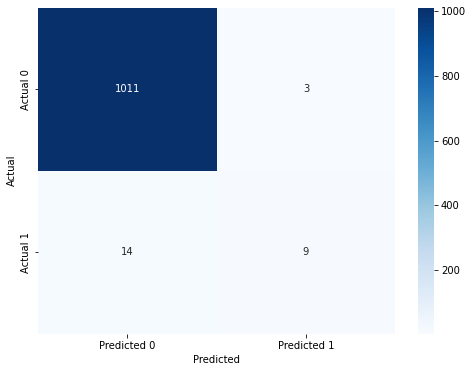

In [34]:
predictions = [1 if pred > 0.8 else 0 for pred in preds]

precision = precision_score(y_test, predictions)*100
print(f'Precision: {precision:.4f}')

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, predictions)

confusion_df = pd.DataFrame(conf_matrix, 
                            index=['Actual 0', 'Actual 1'], 
                            columns=['Predicted 0', 'Predicted 1'])

print(confusion_df)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


The confusion matrix let us see that the model has good outcomes, and the predictive factors are useful to make the predictions.
With a threshold of 80%, the precision of the model is 75%, which we believe the model should prioritize since false positives are costly for farmers.

In [35]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score

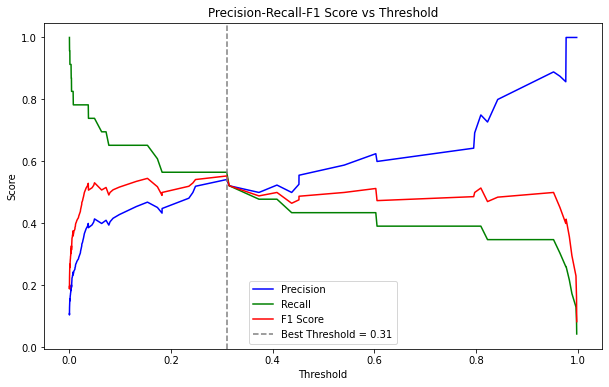

(0.3095605, 0.5531914893617021)

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f1_scores = np.where((precision + recall) > 0, 2 * (precision * recall) / (precision + recall), 0.0001)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='red')
plt.axvline(x=best_threshold, color='gray', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('Precision-Recall-F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

best_threshold, best_f1


We can see that the precision score increases with a higher threshold.

In [37]:
# model_retrieval_hpt is the xgboots instance on your RAM

bst.save_model('model.xgb')

# # retreival save model

# model_from_file = xgb.Booster()
# model_from_file.load_model("./best_model_test/model_to_aws.xgb") # use the same file's direction

/Users/maxbaldiviezo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:07:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## Feature importance: shap values

In [38]:
#!pip install shap

In [39]:
import shap

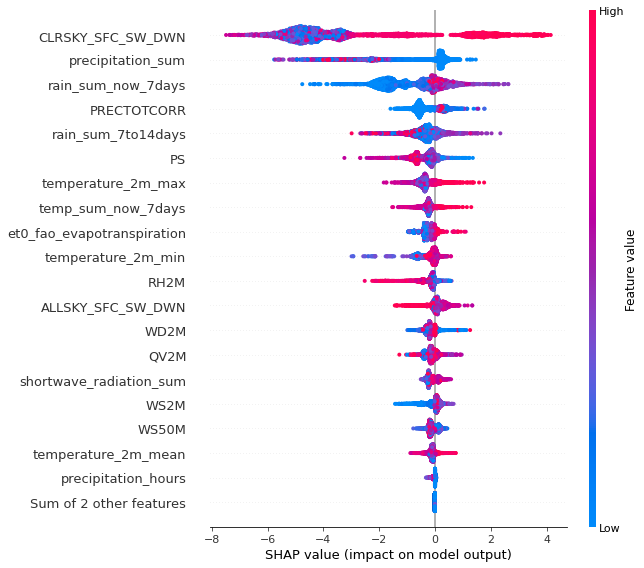

In [40]:
explainer = shap.TreeExplainer(bst)

shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values,max_display=20)

The most important features are: 
Atmospheric pressure, weekly past rain, radiation and temperature, decreasing in importance as the graphic shows.

## Conclusion

We conclude that a classification model is succesful in identifying the optimal weather and environmental conditions to assess 
the end user (farmer) in the decision making process of sowing in that particular day. This model inference will be made accessible for him through a website, mobile application or radio program subscription.

The confusion matrix let us see that the model has good outcomes, and the predictive factors are useful to make the predictions.
With a threshold of 80%, the precision of the model is 75%, which we believe the model should prioritize since false positives are costly for farmers.